## Init

In [5]:
import os

path = os.getcwd()
# set the working directory
os.chdir('c:\\Github\\new-peak-project\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [6]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [7]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

### Notebook Parameters

In [8]:
import os

# parameters
notebook_name = 'test1'

# Generation of ground truth model

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)

# Simulation parameters

simulation_time = 500
simulation_step = 100

# Feature data generation

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000
feature_generation_seed = 50  # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed


data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

# General parameters
parallelise = True
save_figures = True
experiment_id = notebook_name + '_' + \
    str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/test1_4_50/


## Initialise RoadrunnerSolver

In [15]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

rr_solver = RoadrunnerSolver()

In [16]:
### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)

states_variable_names = G0.get_state_variables().keys()

rr_solver.compile(G0.get_sbml_model())
result = rr_solver.simulate(0, simulation_time, simulation_step)
result

,time,A0p,A0,A1p,A1,Cp,A2p,A2,B0p,A3p,...,B0,B1p,B1,B2p,B2,B3p,B3,B4p,B4,C
0,0.000000,0.000000,4494.000000,0.000000,1416.000000,0.000000,0.000000,4344.000000,0.000000,0.000000,...,4266.000000,0.000000,1737.000000,0.000000,870.000000,0.000000,2039.000000,0.000000,3732.000000,100.000000
1,5.050505,5.014860,4488.985140,30.893254,1385.106746,4.459453,21.094524,4322.905476,11.118462,238.413298,...,4254.881538,34.550475,1702.449525,32.514591,837.485409,347.232162,1691.767838,25.939308,3706.060692,95.540547
2,10.101010,7.900836,4486.099164,57.177946,1358.822054,5.423325,36.573242,4307.426758,26.969359,437.491127,...,4239.030641,71.298706,1665.701294,82.073412,787.926588,1223.361648,815.638352,58.164772,3673.835228,94.576675
3,15.151515,9.567235,4484.432765,79.217041,1336.782959,5.975663,48.161434,4295.838566,41.301037,613.676343,...,4224.698963,108.723396,1628.276604,134.041494,735.958506,1890.838488,148.161512,92.619166,3639.380834,94.024337
4,20.202020,10.531279,4483.468721,97.803737,1318.196263,6.330755,57.366652,4286.633348,52.578944,774.178467,...,4213.421056,145.829910,1591.170090,186.137198,683.862802,1993.609292,45.390708,129.770677,3602.229323,93.669245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,479.797980,11.859735,4482.140265,205.006765,1210.993235,6.062400,210.096052,4133.903948,78.540127,3572.500889,...,4187.459873,650.496913,1086.503087,817.560215,52.439785,2030.394570,8.605430,2764.783540,967.216460,93.937600
96,484.848485,11.859735,4482.140265,205.002037,1210.997963,6.061800,210.347752,4133.652248,78.540127,3572.554854,...,4187.459873,650.491538,1086.508462,817.655740,52.344260,2030.394702,8.605298,2765.191662,966.808338,93.938200
97,489.898990,11.859735,4482.140265,204.997339,1211.002661,6.061211,210.591834,4133.408166,78.540127,3572.603074,...,4187.459873,650.485394,1086.514606,817.747871,52.252129,2030.394820,8.605180,2765.576969,966.423031,93.938789
98,494.949495,11.859735,4482.140265,204.992679,1211.007321,6.060635,210.828532,4133.171468,78.540127,3572.646159,...,4187.459873,650.478575,1086.521425,817.836802,52.163198,2030.394925,8.605075,2765.940790,966.059210,93.939365


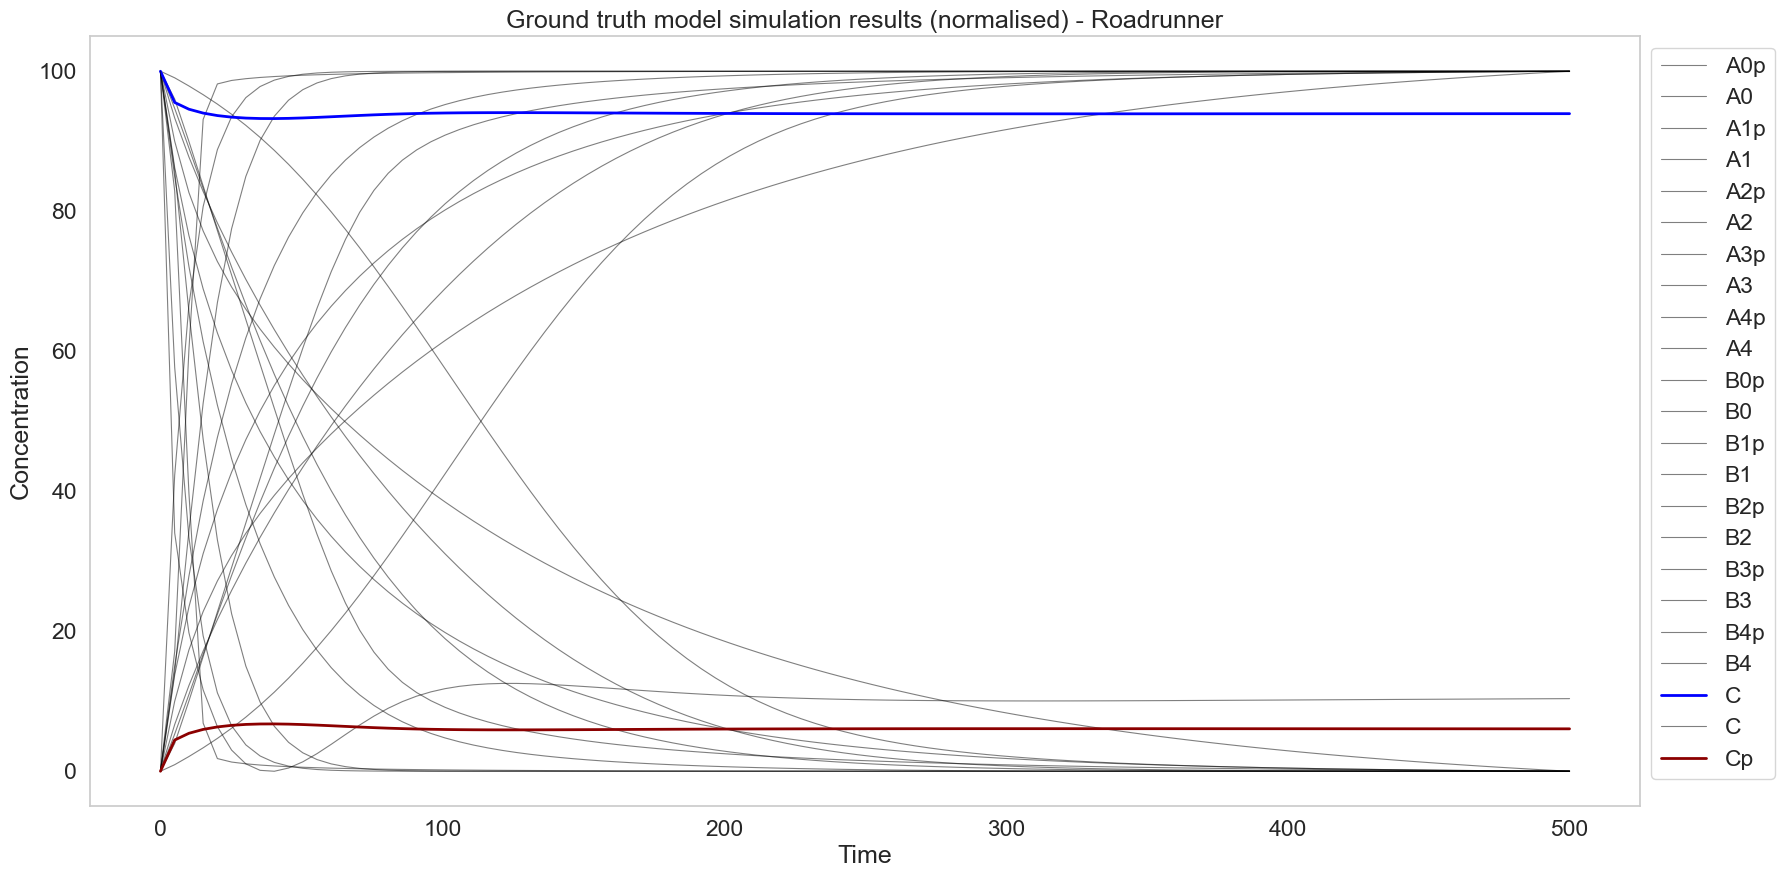

In [17]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [18]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(4, 5, 2, verbose=0)
drug_0 = Drug('D0', 500, 5000)
drug_0.add_regulation('A0', 'down')
drug_0.add_regulation('A1', 'down')
drug_0.add_regulation('A2', 'down')
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [(np.str_('C'), np.str_('A1')), (np.str_('B0'), np.str_('A2')), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('B0', 'C'), ('B1', 'C'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2')]
Regulation Types: [np.str_('up'), np.str_('down'), 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2'], ['down', 'down', 'down'])

Feedback: [((np.str_('C'), np.str_('A1')), np.str_('up')), ((np.str_('B0'), np.str_('A2')), np.str_('down'))]


In [19]:
GD0 = model_drug_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)

states_variable_names = GD0.get_state_variables().keys()

rr_solver.compile(GD0.get_sbml_model())
result = rr_solver.simulate(0, 1000, simulation_step)
result

,time,A0p,A0,A1p,A1,Cp,A2p,A2,B0p,A3p,...,B0,B1p,B1,B2p,B2,B3p,B3,B4p,B4,C
0,0.00000,0.000000,4494.000000,0.000000,154.000000,0.000000,0.000000,3447.000000,0.000000,0.000000,...,2966.000000,0.000000,753.000000,0.000000,2644.000000,0.000000,1689.000000,0.000000,426.000000,100.000000
1,10.10101,0.788136,4493.211864,3.799919,150.200081,9.264352,49.991845,3397.008155,18.660905,63.103797,...,2947.339095,24.083438,728.916562,228.773797,2415.226203,85.576254,1603.423746,423.956438,2.043562,90.735648
2,20.20202,1.046906,4492.953094,3.456600,150.543400,6.697752,82.788091,3364.211909,22.362849,90.783993,...,2943.637151,48.360504,704.639496,620.672411,2023.327589,197.185982,1491.814018,424.813126,1.186874,93.302248
3,30.30303,1.131930,4492.868070,2.974361,151.025639,5.173780,110.542658,3336.457342,23.290545,105.418789,...,2942.709455,69.640167,683.359833,1127.919059,1516.080941,290.283188,1398.716812,425.080811,0.919189,94.826220
4,40.40404,1.159870,4492.840130,2.674903,151.325097,4.262757,135.307790,3311.692210,23.557148,113.693197,...,2942.442852,88.513447,664.486553,1704.656501,939.343499,361.865776,1327.134224,425.206230,0.793770,95.737243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,0.007523,4493.992477,0.031432,153.968568,25.106087,5.324459,3441.675541,19.418308,125.752279,...,2946.581692,299.962507,453.037493,147.908883,2496.091117,541.971151,1147.028849,425.387670,0.612330,74.893913
96,969.69697,0.007523,4493.992477,0.031641,153.968359,25.292840,4.961297,3442.038703,19.418308,125.752279,...,2946.581692,299.680083,453.319917,140.599734,2503.400266,541.971151,1147.028849,425.387670,0.612330,74.707160
97,979.79798,0.007523,4493.992477,0.031811,153.968189,25.446154,4.644639,3442.355361,19.418308,125.752279,...,2946.581692,299.412950,453.587050,134.648055,2509.351945,541.971151,1147.028849,425.387670,0.612330,74.553846
98,989.89899,0.007523,4493.992477,0.031952,153.968048,25.573900,4.368585,3442.631415,19.418308,125.752279,...,2946.581692,299.160250,453.839750,129.721309,2514.278691,541.971151,1147.028849,425.387670,0.612330,74.426100


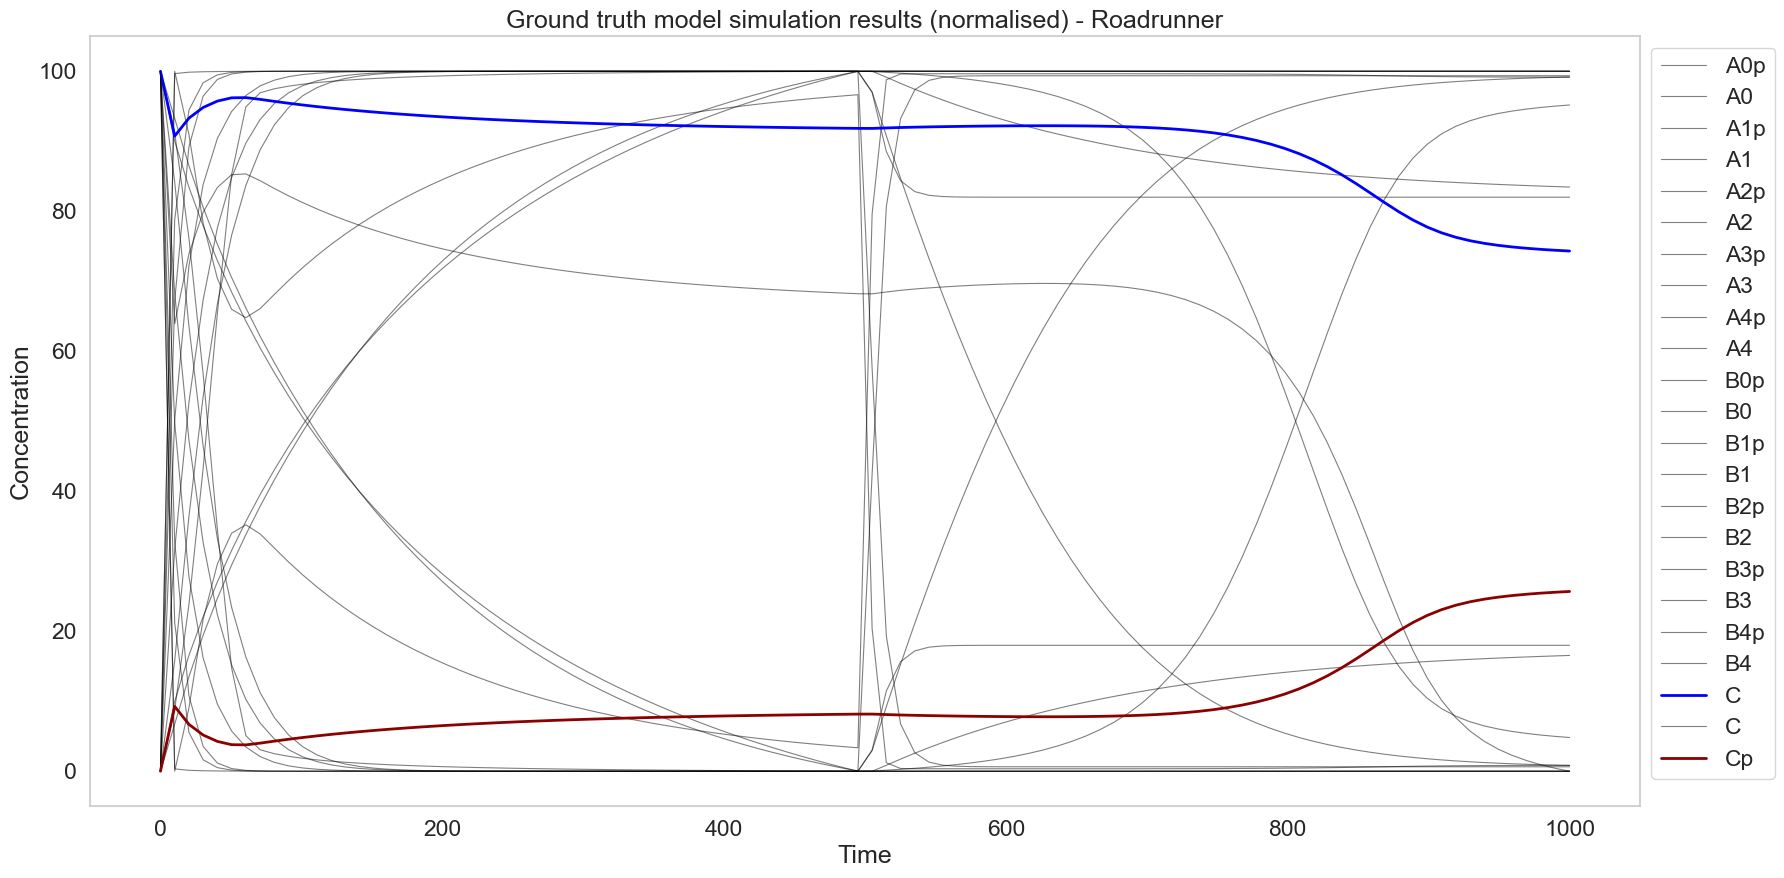

In [20]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

## ScipySolver

In [9]:
from models.Solver.ScipySolver import ScipySolver

solver = ScipySolver()

In [10]:
### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)

states_variable_names = G0.get_state_variables().keys()

solver.compile(G0.get_antimony_model())
result = solver.simulate(0, simulation_time, simulation_step)
result

,time,A0,A0p,A1,A1p,A2,A2p,A3,A3p,A4,...,B1,B1p,B2,B2p,B3,B3p,B4,B4p,C,Cp
0,0.000000,4494.000000,0.000000,1416.000000,0.000000,4344.000000,0.000000,4288.000000,0.000000,4812.000000,...,1737.000000,0.000000,870.000000,0.000000,2039.000000,0.000000,3732.000000,0.000000,100.000000,0.000000
1,5.050505,4488.985140,5.014860,1385.106691,30.893309,4322.905477,21.094523,4049.586699,238.413301,4594.046217,...,1702.449519,34.550481,837.485412,32.514588,1691.767985,347.232015,3706.060705,25.939295,95.540422,4.459578
2,10.101010,4486.099164,7.900836,1358.821891,57.178109,4307.426775,36.573225,3850.508822,437.491178,4440.216226,...,1665.701253,71.298747,787.926682,82.073318,815.640131,1223.359869,3673.835254,58.164746,94.576513,5.423487
3,15.151515,4484.432765,9.567235,1336.782680,79.217320,4295.838584,48.161416,3674.323597,613.676403,4319.493221,...,1628.276499,108.723501,735.958615,134.041385,148.161448,1890.838552,3639.380826,92.619174,94.024196,5.975804
4,20.202020,4483.468721,10.531279,1318.195906,97.804094,4286.633364,57.366636,3513.821477,774.178523,4219.835059,...,1591.169900,145.830100,683.862905,186.137095,45.391239,1993.608761,3602.229289,129.770711,93.669124,6.330876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,479.797980,4482.140265,11.859735,1210.993241,205.006759,4133.903947,210.096053,715.500174,3572.499826,3228.739677,...,1086.503145,650.496855,52.439837,817.560163,8.605432,2030.394568,967.217090,2764.782910,93.937600,6.062400
96,484.848485,4482.140265,11.859735,1210.997969,205.002031,4133.652248,210.347752,715.446146,3572.553854,3228.497142,...,1086.508519,650.491481,52.344496,817.655504,8.605300,2030.394700,966.808923,2765.191077,93.938201,6.061799
97,489.898990,4482.140265,11.859735,1211.002666,204.997334,4133.408168,210.591832,715.397863,3572.602137,3228.267689,...,1086.514662,650.485338,52.252372,817.747628,8.605183,2030.394817,966.423576,2765.576424,93.938789,6.061211
98,494.949495,4482.140265,11.859735,1211.007327,204.992673,4133.171471,210.828529,715.354716,3572.645284,3228.050609,...,1086.521480,650.478520,52.163345,817.836655,8.605077,2030.394923,966.059717,2765.940283,93.939365,6.060635


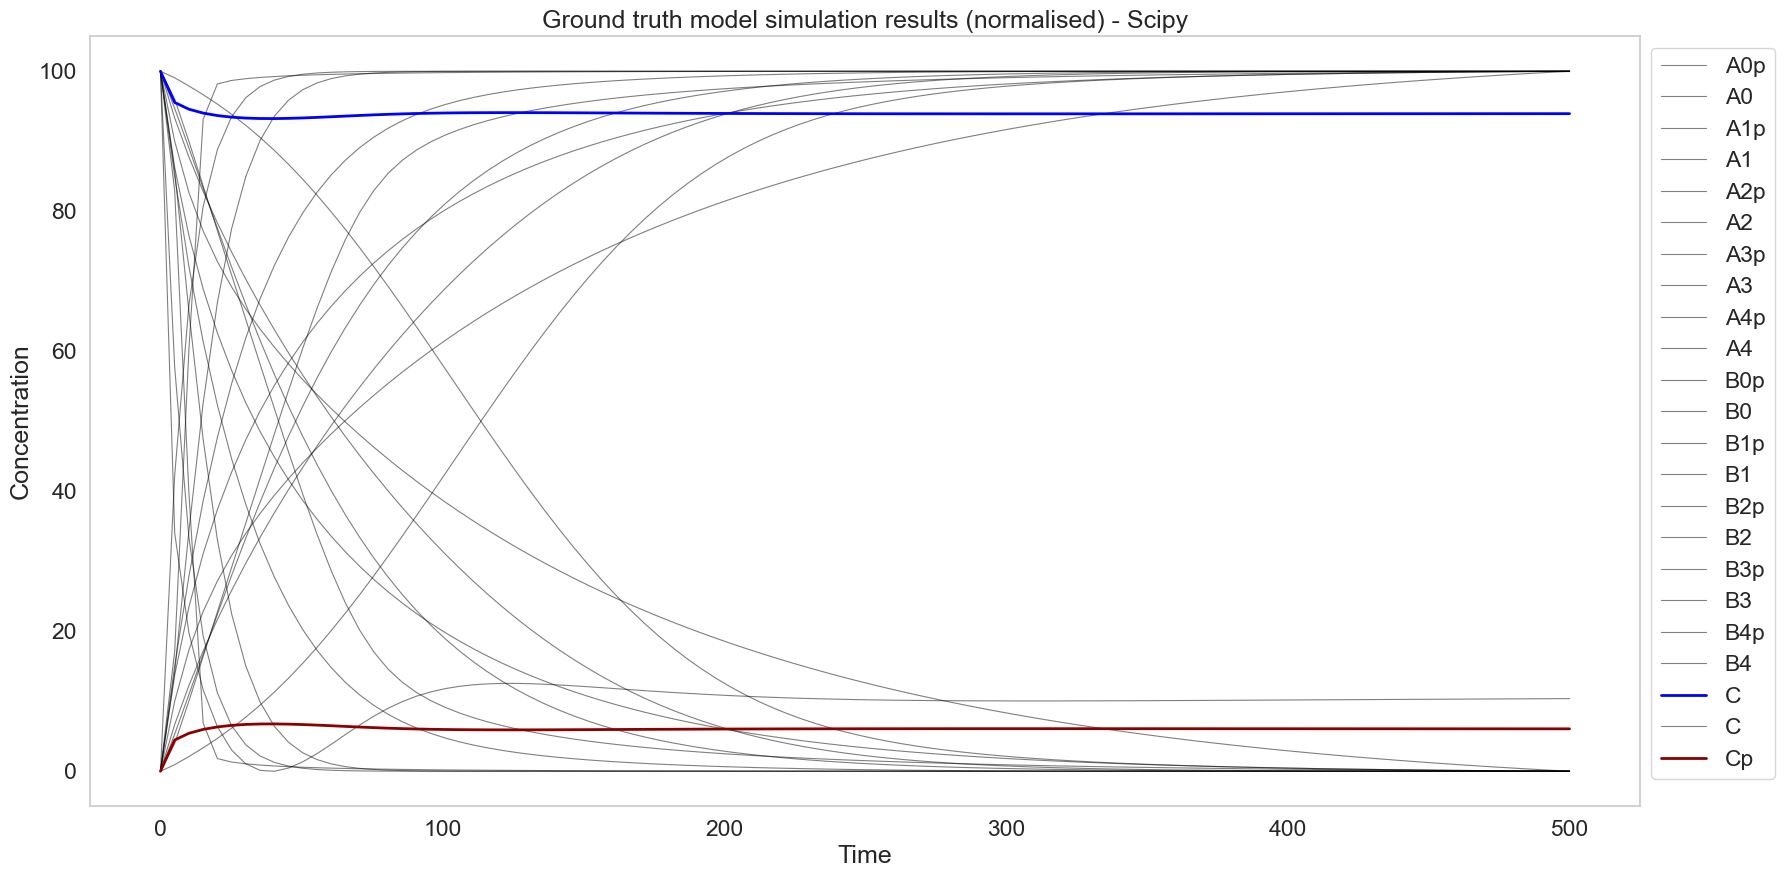

In [11]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Scipy')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [12]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(4, 5, 2, verbose=0)
drug_0 = Drug('D0', 500, 5000)
drug_0.add_regulation('A0', 'down')
drug_0.add_regulation('A1', 'down')
drug_0.add_regulation('A2', 'down')
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [(np.str_('C'), np.str_('A1')), (np.str_('B0'), np.str_('A2')), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('B0', 'C'), ('B1', 'C'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2')]
Regulation Types: [np.str_('up'), np.str_('down'), 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2'], ['down', 'down', 'down'])

Feedback: [((np.str_('C'), np.str_('A1')), np.str_('up')), ((np.str_('B0'), np.str_('A2')), np.str_('down'))]


In [13]:
GD0 = model_drug_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)

states_variable_names = GD0.get_state_variables().keys()

solver.compile(GD0.get_antimony_model())
print(solver.assignment_rules)
result = solver.simulate(0, 1000, simulation_step)
result

{'D0': {'before': 0.0, 'after': 5000.0, 'time': 500.0}}


,time,A0,A0p,A1,A1p,A2,A2p,A3,A3p,A4,...,B1,B1p,B2,B2p,B3,B3p,B4,B4p,C,Cp
0,0.00000,4494.000000,0.000000,154.000000,0.000000,3447.000000,0.000000,1085.000000,0.000000,1088.000000,...,753.000000,0.000000,2644.000000,0.000000,1689.000000,0.000000,426.000000,0.000000,100.000000,0.000000
1,10.10101,4493.211864,0.788136,150.200082,3.799918,3397.008142,49.991858,1021.896197,63.103803,851.933890,...,728.916566,24.083434,2415.226184,228.773816,1603.423760,85.576240,2.043557,423.956443,90.735642,9.264358
2,20.20202,4492.953093,1.046907,150.543391,3.456609,3364.211868,82.788132,994.215936,90.784064,695.207445,...,704.639501,48.360499,2023.327403,620.672597,1491.814078,197.185922,1.186874,424.813126,93.302248,6.697752
3,30.30303,4492.868070,1.131930,151.025639,2.974361,3336.457316,110.542684,979.581174,105.418826,585.812951,...,683.359833,69.640167,1516.080542,1127.919458,1398.716724,290.283276,0.919191,425.080809,94.826221,5.173779
4,40.40404,4492.840128,1.159872,151.325104,2.674896,3311.692159,135.307841,971.306651,113.693349,509.087266,...,664.486541,88.513459,939.332901,1704.667099,1327.134076,361.865924,0.793769,425.206231,95.737271,4.262729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,4493.992477,0.007523,153.968681,0.031319,3441.490367,5.509633,959.247721,125.752279,342.358624,...,452.948340,300.051660,2492.128389,151.871611,1147.028849,541.971151,0.612330,425.387670,74.995036,25.004964
96,969.69697,4493.992477,0.007523,153.968451,0.031549,3441.877216,5.122784,959.247721,125.752279,342.358624,...,453.235648,299.764352,2500.219371,143.780629,1147.028849,541.971151,0.612330,425.387670,74.789201,25.210799
97,979.79798,4493.992477,0.007523,153.968264,0.031736,3442.214561,4.785439,959.247721,125.752279,342.358624,...,453.507381,299.492619,2506.748666,137.251334,1147.028849,541.971151,0.612330,425.387670,74.621555,25.378445
98,989.89899,4493.992477,0.007523,153.968111,0.031889,3442.508676,4.491324,959.247721,125.752279,342.358624,...,453.764417,299.235583,2512.115223,131.884777,1147.028849,541.971151,0.612330,425.387670,74.482761,25.517239


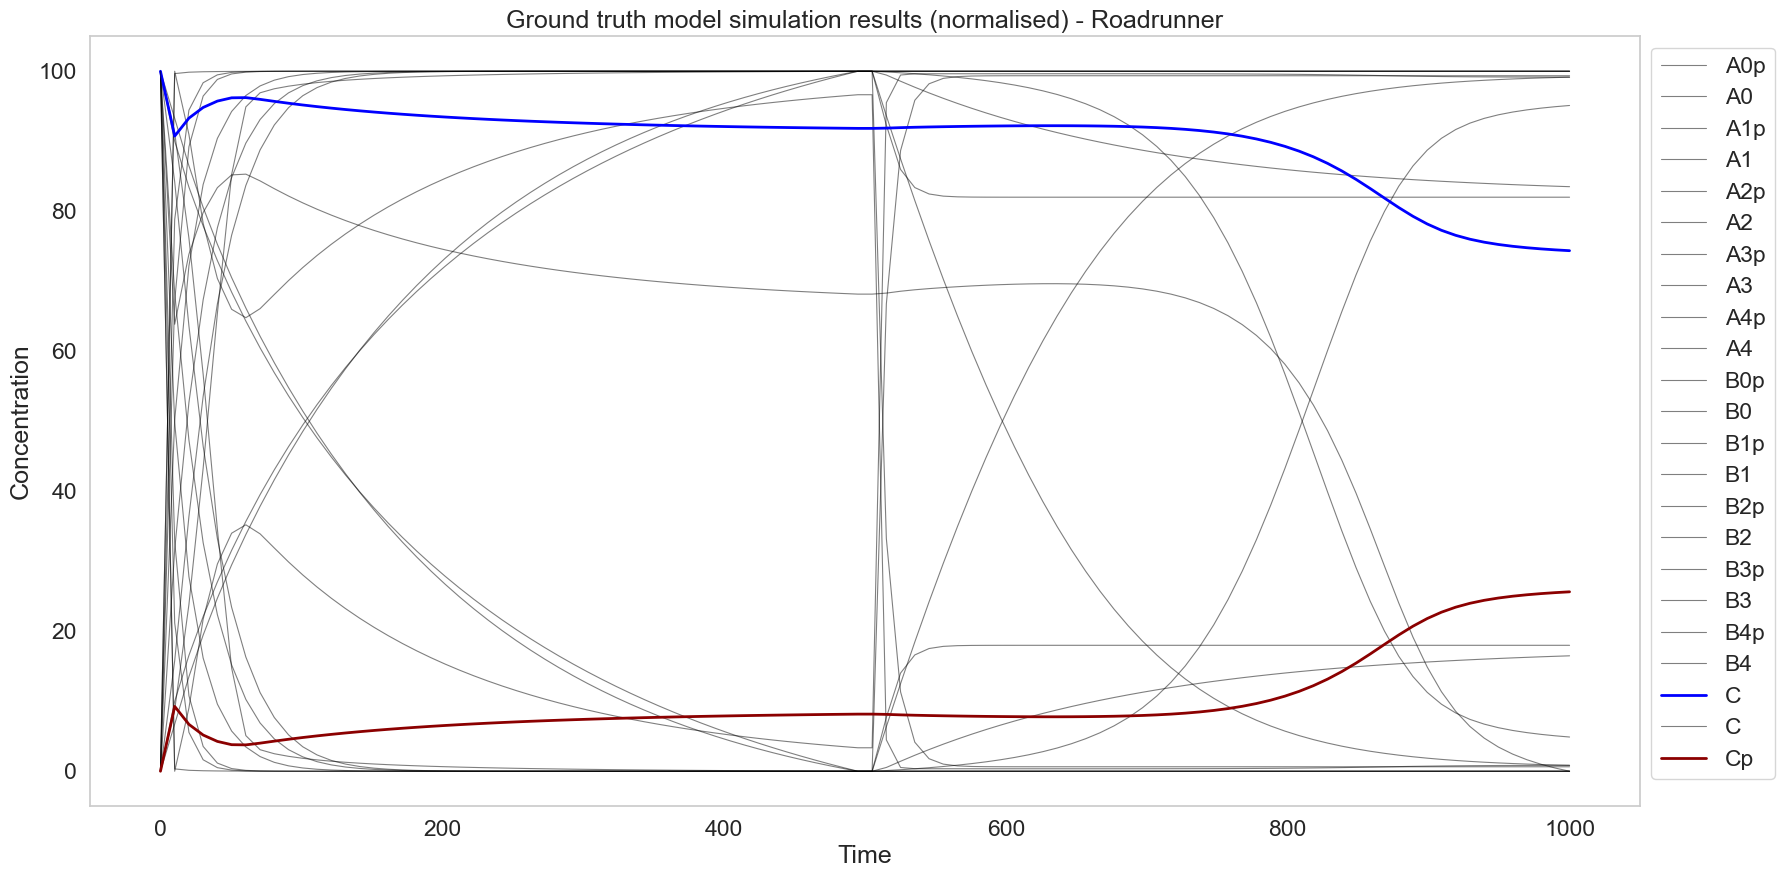

In [14]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [22]:
solver.compile(GD0.get_antimony_model(), **{'jit': True})
result = solver.simulate(0, 1000, simulation_step)
result

,time,A0,A0p,A1,A1p,A2,A2p,A3,A3p,A4,...,B1,B1p,B2,B2p,B3,B3p,B4,B4p,C,Cp
0,0.00000,4494.000000,0.000000,154.000000,0.000000,3447.000000,0.000000,1085.000000,0.000000,1088.000000,...,753.000000,0.000000,2644.000000,0.000000,1689.000000,0.000000,426.000000,0.000000,100.000000,0.000000
1,10.10101,4493.211864,0.788136,150.200082,3.799918,3397.008142,49.991858,1021.896197,63.103803,851.933890,...,728.916566,24.083434,2415.226184,228.773816,1603.423760,85.576240,2.043557,423.956443,90.735642,9.264358
2,20.20202,4492.953093,1.046907,150.543391,3.456609,3364.211868,82.788132,994.215936,90.784064,695.207445,...,704.639501,48.360499,2023.327403,620.672597,1491.814078,197.185922,1.186874,424.813126,93.302248,6.697752
3,30.30303,4492.868070,1.131930,151.025639,2.974361,3336.457316,110.542684,979.581174,105.418826,585.812951,...,683.359833,69.640167,1516.080542,1127.919458,1398.716724,290.283276,0.919191,425.080809,94.826221,5.173779
4,40.40404,4492.840128,1.159872,151.325104,2.674896,3311.692159,135.307841,971.306651,113.693349,509.087266,...,664.486541,88.513459,939.332901,1704.667099,1327.134076,361.865924,0.793769,425.206231,95.737271,4.262729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,4493.992477,0.007523,153.968681,0.031319,3441.490367,5.509633,959.247721,125.752279,342.358624,...,452.948340,300.051660,2492.128389,151.871611,1147.028849,541.971151,0.612330,425.387670,74.995036,25.004964
96,969.69697,4493.992477,0.007523,153.968451,0.031549,3441.877216,5.122784,959.247721,125.752279,342.358624,...,453.235648,299.764352,2500.219371,143.780629,1147.028849,541.971151,0.612330,425.387670,74.789201,25.210799
97,979.79798,4493.992477,0.007523,153.968264,0.031736,3442.214561,4.785439,959.247721,125.752279,342.358624,...,453.507381,299.492619,2506.748666,137.251334,1147.028849,541.971151,0.612330,425.387670,74.621555,25.378445
98,989.89899,4493.992477,0.007523,153.968111,0.031889,3442.508676,4.491324,959.247721,125.752279,342.358624,...,453.764417,299.235583,2512.115223,131.884777,1147.028849,541.971151,0.612330,425.387670,74.482761,25.517239


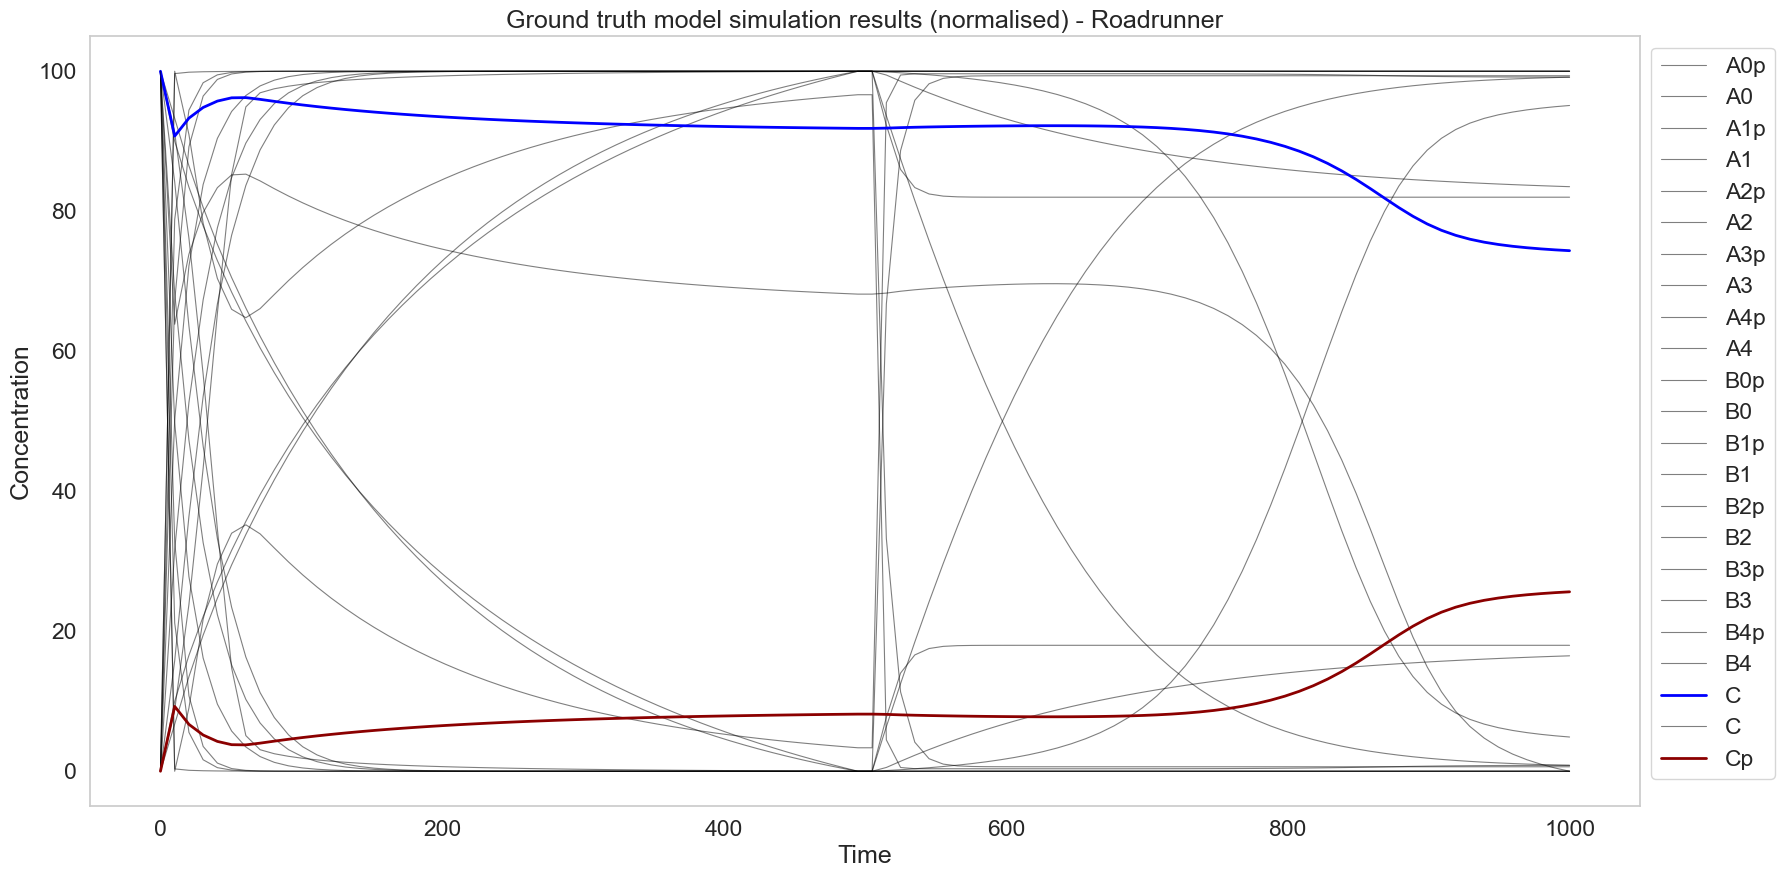

In [23]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

## AMICISolver 

Requires the container jupyter notebook to run

In [1]:
import os 
path = os.getcwd()
print('Current working directory:', path)

# change the working directory to '/\new-peak-project'

os.chdir('/new-peak-project/src')
print('Changed working directory to:', os.getcwd())

Current working directory: /app
Changed working directory to: /new-peak-project/src


In [2]:
# set the results directory to '/new-peak-project/src/experiments'
results_path = '/new-peak-project/src/experiments'
print('Results directory set to:', results_path)

Results directory set to: /new-peak-project/src/experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

In [4]:
import os

# parameters
notebook_name = 'test1'
sub_id = '1'

# Generation of ground truth model

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)

# Simulation parameters

simulation_time = 500
simulation_step = 100

# Feature data generation

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000
feature_generation_seed = 50  # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed


data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''
# General parameters
parallelise = True
save_figures = True
experiment_id = notebook_name + '_' + sub_id
experiment_folder = results_path + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

print(experiment_folder)

/new-peak-project/src/experiments/test1_1/


In [5]:
from models.Solver.AMICISolver import AMICISolver

solver = AMICISolver()

In [6]:
### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
states_variable_names = G0.get_state_variables().keys()

# save the sbml model to the results folder
sbml_file = experiment_folder + model_name + '.xml'
with open(sbml_file, 'w') as f:
    f.write(G0.get_sbml_model())
print('SBML model saved to:', sbml_file)

SBML model saved to: /new-peak-project/src/experiments/test1_1/v3_small_model_52.xml


In [7]:
kw = {'model_dir': 'model_dir', 'model_name': model_name}
solver.compile(sbml_file, **kw)

2025-05-01 05:23:47.336 - amici.sbml_import - INFO - Finished importing SBML                         (1.43E-01s)
2025-05-01 05:23:47.389 - amici.sbml_import - INFO - Finished processing SBML observables            (4.54E-02s)
2025-05-01 05:23:47.396 - amici.sbml_import - INFO - Finished processing SBML event observables      (1.20E-06s)
2025-05-01 05:23:47.481 - amici.de_model - INFO - Finished computing xdot                            (2.36E-04s)
2025-05-01 05:23:47.488 - amici.de_model - INFO - Finished computing x0                              (1.62E-04s)
2025-05-01 05:23:47.495 - amici.de_model - INFO - Finished computing w                               (1.46E-04s)
2025-05-01 05:23:48.643 - amici.de_export - INFO - Finished generating cpp code                      (1.14E+00s)
2025-05-01 05:24:03.812 - amici.de_export - INFO - Finished compiling cpp code                       (1.52E+01s)


In [8]:
result = solver.simulate(0, simulation_time, simulation_step)
result

,time,A0p,A0,A1p,A1,Cp,A2p,A2,B0p,A3p,...,B0,B1p,B1,B2p,B2,B3p,B3,B4p,B4,C
0,0.000000,0.000000,4494.000000,0.000000,1416.000000,0.000000,0.000000,4344.000000,0.000000,0.000000,...,4266.000000,0.000000,1737.000000,0.000000,870.000000,0.000000,2039.000000,0.000000,3732.000000,100.000000
1,5.050505,5.014860,4488.985140,30.893308,1385.106692,4.459577,21.094523,4322.905477,11.118462,238.413301,...,4254.881538,34.550481,1702.449519,32.514588,837.485412,347.232010,1691.767990,25.939296,3706.060704,95.540423
2,10.101010,7.900836,4486.099164,57.178107,1358.821893,5.423485,36.573226,4307.426774,26.969349,437.491177,...,4239.030651,71.298747,1665.701253,82.073320,787.926680,1223.359924,815.640076,58.164747,3673.835253,94.576515
3,15.151515,9.567235,4484.432765,79.217317,1336.782683,5.975802,48.161416,4295.838584,41.301027,613.676402,...,4224.698973,108.723500,1628.276500,134.041387,735.958613,1890.838516,148.161484,92.619174,3639.380826,94.024198
4,20.202020,10.531279,4483.468721,97.804089,1318.195911,6.330874,57.366637,4286.633363,52.578939,774.178521,...,4213.421061,145.830098,1591.169902,186.137097,683.862903,1993.608762,45.391238,129.770710,3602.229290,93.669126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,479.797980,11.859735,4482.140265,205.006759,1210.993241,6.062400,210.096051,4133.903949,78.540127,3572.499826,...,4187.459873,650.496854,1086.503146,817.560162,52.439838,2030.394568,8.605432,2764.782902,967.217098,93.937600
96,484.848485,11.859735,4482.140265,205.002031,1210.997969,6.061799,210.347750,4133.652250,78.540127,3572.553856,...,4187.459873,650.491480,1086.508520,817.655503,52.344497,2030.394700,8.605300,2765.191070,966.808930,93.938201
97,489.898990,11.859735,4482.140265,204.997333,1211.002667,6.061211,210.591830,4133.408170,78.540127,3572.602143,...,4187.459873,650.485337,1086.514663,817.747627,52.252373,2030.394817,8.605183,2765.576422,966.423578,93.938789
98,494.949495,11.859735,4482.140265,204.992673,1211.007327,6.060635,210.828527,4133.171473,78.540127,3572.645290,...,4187.459873,650.478519,1086.521481,817.836655,52.163345,2030.394923,8.605077,2765.940280,966.059720,93.939365


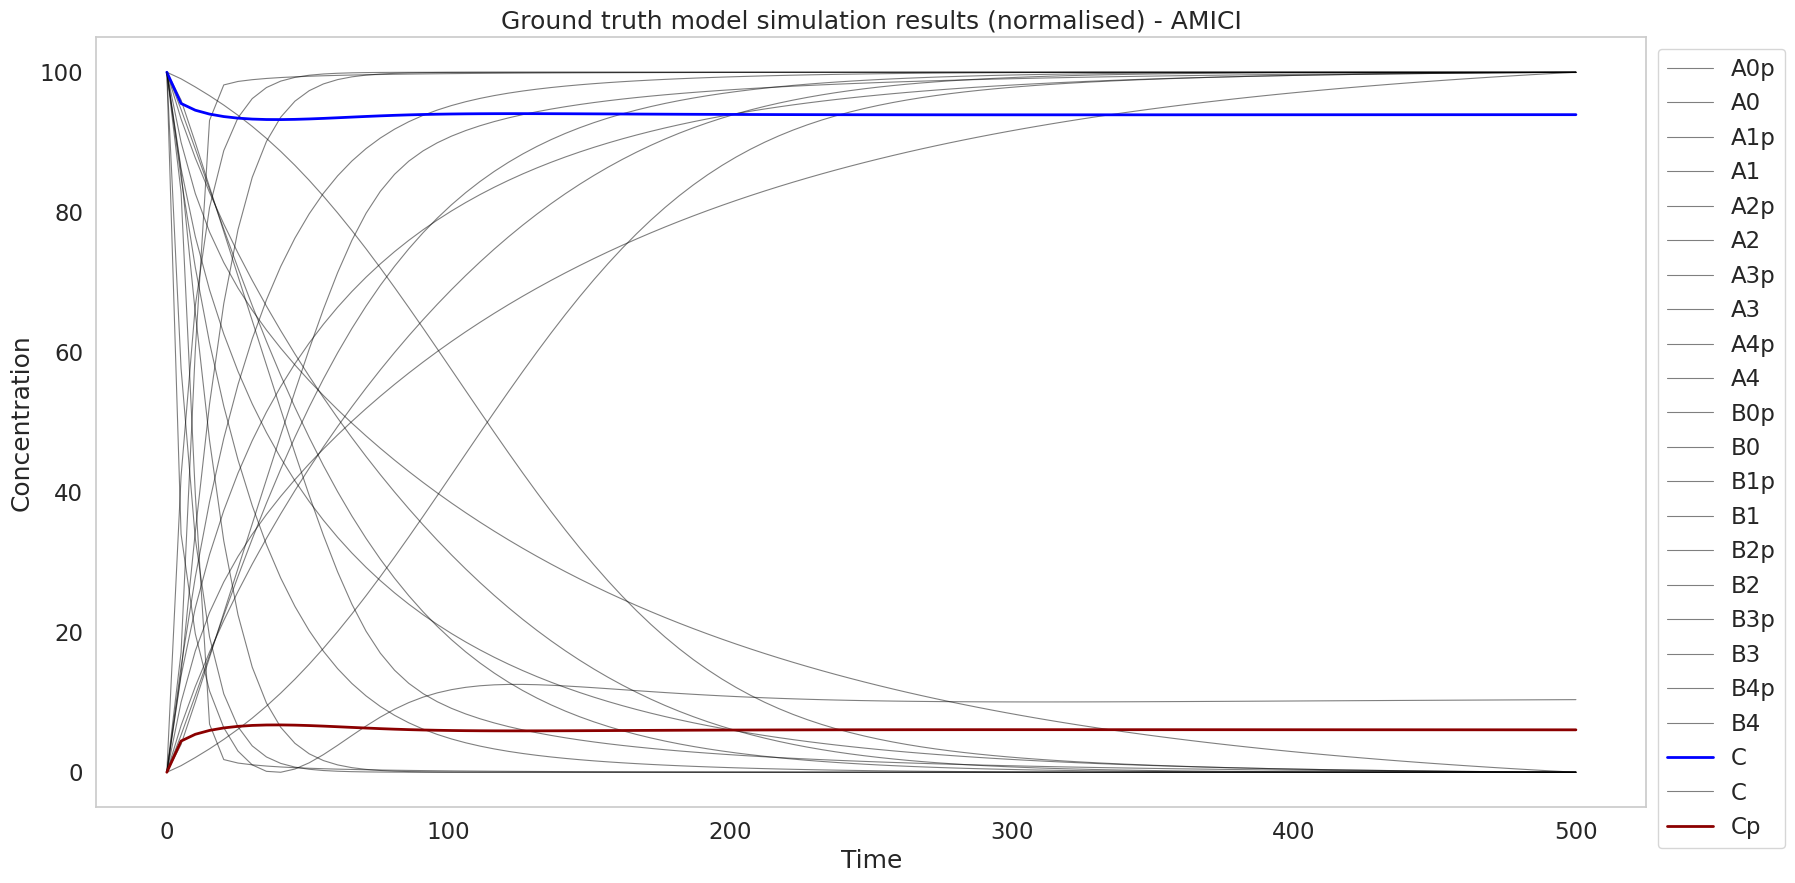

In [9]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - AMICI')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()